Using TensorFlow backend.
/home/mizio/anaconda2/envs/kaggle_env_pyth36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



 TRAINING DATA:----------------------------------------------- 

1424
1813
  timestamp derived_0                  derived_1                  derived_2  \
                 mean       std    len      mean       std    len      mean   
0         0  0.039326  0.792450  750.0  0.111924  0.423766  750.0 -0.100055   
1         1  0.038036  0.797048  750.0  0.220014  2.570492  750.0  0.779802   
2         2  0.037680  0.799508  750.0  0.221317  2.571858  750.0  0.789735   
3         3  0.037372  0.801825  750.0  0.222442  2.573150  750.0  0.798304   
4         4  0.036876  0.805932  750.0  0.224254  2.575450  750.0  0.812107   

                    derived_3                  derived_4                   
         std    len      mean       std    len      mean       std    len  
0   3.133463  750.0 -0.093836  2.626800  750.0  0.080802  0.581652  750.0  
1  19.183546  750.0 -0.038055  2.331736  750.0  0.081712  0.582439  750.0  
2  19.158264  750.0 -0.025887  2.215398  750.0  0.082096  0.583017

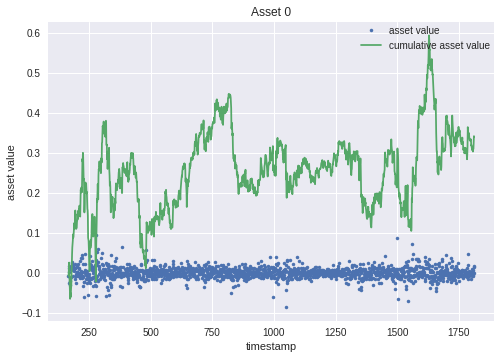

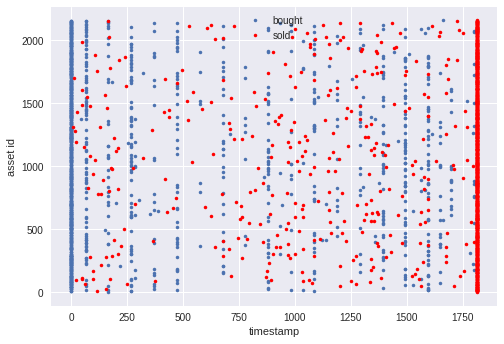

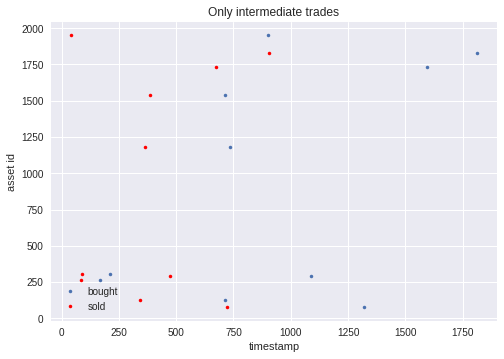

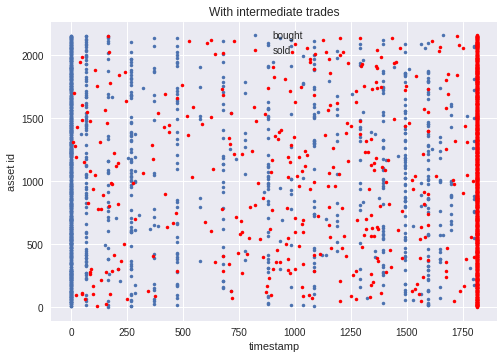

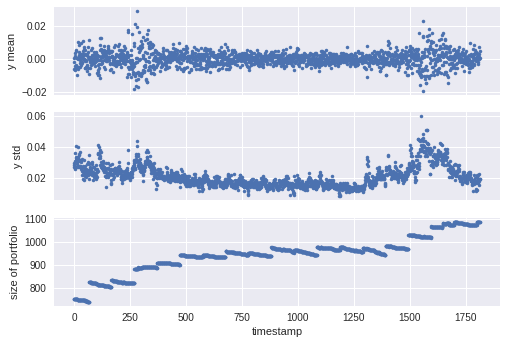

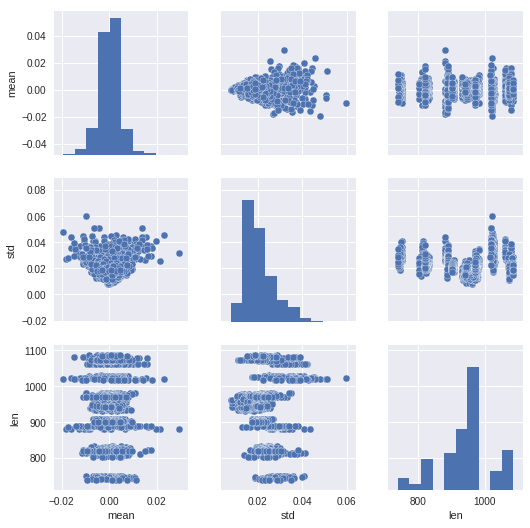

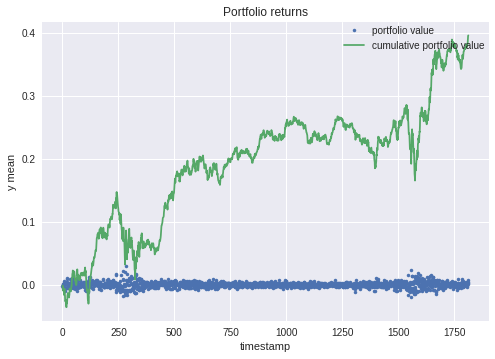

[MICE] Completing matrix with shape (1813, 110)
[MICE] Starting imputation round 1/110, elapsed time 0.002
[MICE] Starting imputation round 2/110, elapsed time 0.102
[MICE] Starting imputation round 3/110, elapsed time 0.153
[MICE] Starting imputation round 4/110, elapsed time 0.206
[MICE] Starting imputation round 5/110, elapsed time 0.259
[MICE] Starting imputation round 6/110, elapsed time 0.311
[MICE] Starting imputation round 7/110, elapsed time 0.363
[MICE] Starting imputation round 8/110, elapsed time 0.422
[MICE] Starting imputation round 9/110, elapsed time 0.477
[MICE] Starting imputation round 10/110, elapsed time 0.531
[MICE] Starting imputation round 11/110, elapsed time 0.586
[MICE] Starting imputation round 12/110, elapsed time 0.643
[MICE] Starting imputation round 13/110, elapsed time 0.699
[MICE] Starting imputation round 14/110, elapsed time 0.753
[MICE] Starting imputation round 15/110, elapsed time 0.807
[MICE] Starting imputation round 16/110, elapsed time 0.862
[

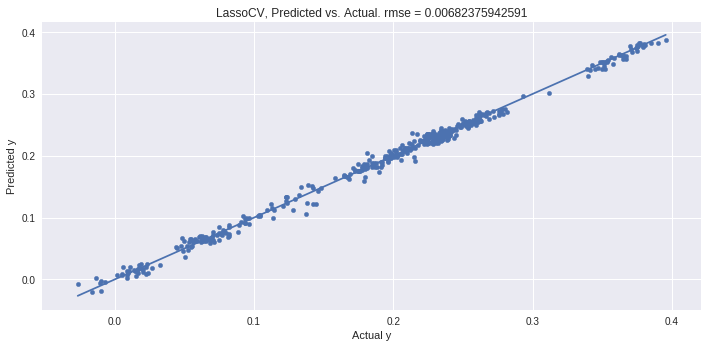

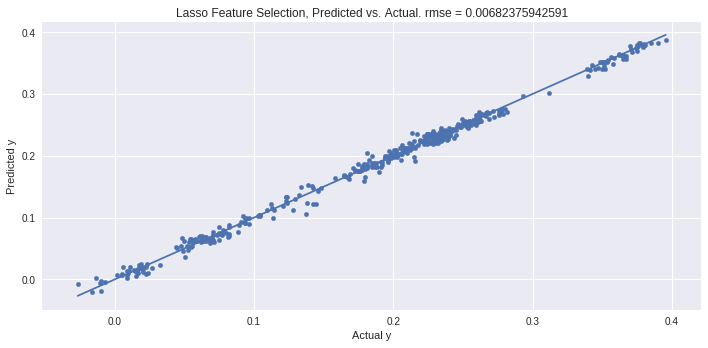

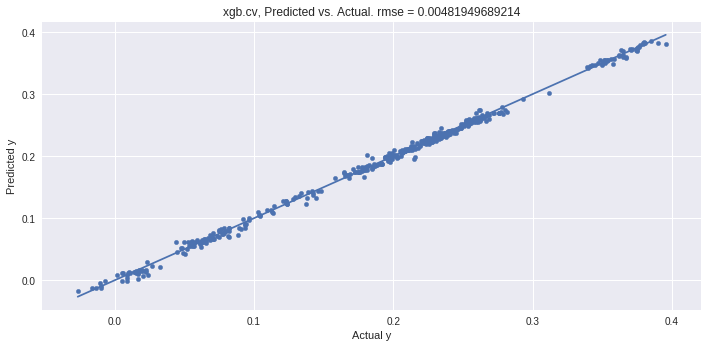

20170707_13h10m51s


In [1]:
# Model portfolio returns using time series analysis
__author__ = 'Mizio'

# Not so often used imports
# import csv as csv
# import matplotlib
# matplotlib.use('TkAgg')
# import sys
# sys.path.append('/custom/path/to/modules')
# from sklearn.model_selection import cross_val_score

# Used imports
import numpy as np
import pandas as pd
import pylab as plt
from fancyimpute import MICE
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import skew
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn_pandas import DataFrameMapper
import xgboost as xgb
from matplotlib.backends.backend_pdf import PdfPages
import datetime
from sklearn.cluster import FeatureAgglomeration
import seaborn as sns

class TwoSigmaFinModTools:
    def __init__(self, is_portfolio_predictions=0, number_of_assets_in_portfolio=11):
        self.correlation_coeffecients = []
        self.is_portfolio_predictions = is_portfolio_predictions
        self.df = TwoSigmaFinModTools.df
        self.number_of_assets_in_portfolio = number_of_assets_in_portfolio
        # self.df_test = TwoSigmaFinModTools.df_test
        self.df_all_feature_var_names = []
        self.df_test_all_feature_var_names = []
        self.timestamp = datetime.datetime.now().strftime('%Y%m%d_%Hh%Mm%Ss')
        self.is_with_log1p_call_outcome = 0

    # Private variables
    _non_numerical_feature_names = []
    _numerical_feature_names = []
    _is_one_hot_encoder = 0
    _feature_names_num = []
    _save_path = '/home/mizio/Documents/Kaggle/TwoSigmaFinancialModelling/'
    _is_not_import_data = 0
    is_dataframe_with_target_value = 1

    ''' Pandas Data Frame '''
    # Load the data from the HDF5 file instead of csv. The file consist only of training data.
    # For upload.
    # with pd.HDFStore("../input/train.h5", "r") as train:
    # For local run.
    # Training data
    with pd.HDFStore("/home/mizio/Documents/Kaggle/TwoSigmaFinancialModelling/input/train.h5", "r") as train:
        df = train.get("train")

    # Only training data was provided
    # df_test = []

    @staticmethod
    def square_feet_to_meters(area):
        square_meter_per_square_feet = 0.3048**2
        return area*square_meter_per_square_feet

    @staticmethod
    def extract_numerical_features(df):
        df = df.copy()
        df = df.copy()
        non_numerical_feature_names = df.columns[np.where(TwoSigmaFinModTools.numerical_feature_logical_incl_hidden_num(
            df) == 0)]
        return non_numerical_feature_names

    @staticmethod
    def extract_non_numerical_features(df):
        df = df.copy()
        non_numerical_feature_names = df.columns[np.where(TwoSigmaFinModTools.numerical_feature_logical_incl_hidden_num(
            df))]
        return non_numerical_feature_names

    @staticmethod
    def numerical_feature_logical_incl_hidden_num(df):
        logical_of_non_numeric_features = np.zeros(df.columns.shape[0], dtype=int)
        for ite in np.arange(0, df.columns.shape[0]):
            try:
                str(df[df.columns[ite]][0]) + df[df.columns[ite]][0]
                logical_of_non_numeric_features[ite] = True
            except TypeError:
                # print('Oops')
                hack = ''
        return logical_of_non_numeric_features

    def clean_data(self, df, is_with_MICE=0):
        df = df.copy()
        if df.isnull().sum().sum() > 0:
            if is_with_MICE:
                # Imputation using MICE
                numerical_features_names = self.extract_numerical_features(df)
                df.loc[:, tuple(numerical_features_names)] = self.estimate_by_mice(df[numerical_features_names])
            else:
                if any(tuple(df.columns == 'y')):
                    df = df.dropna()
                else:
                    df = df.dropna(1)
                    TwoSigmaFinModTools._feature_names_num = pd.Series(data=np.intersect1d(
                        TwoSigmaFinModTools._feature_names_num.values, df.columns), dtype=object)
        TwoSigmaFinModTools._numerical_feature_names = TwoSigmaFinModTools.extract_numerical_features(df)
        return df

    @staticmethod
    def encode_labels_in_numeric_format(df, estimated_var):
        # Transform non-numeric labels into numerical values
        # Cons.: gives additional unwanted structure to data, since some values are high and others low, despite labels
        # where no such comparing measure exists.
        # Alternative: use one-hot-encoding giving all labels their own column represented with only binary values.
        feature_name_num = ''.join([estimated_var, 'Num'])
        mask = ~df[estimated_var].isnull()
        df[feature_name_num] = df[estimated_var]
        df.loc[mask, tuple([feature_name_num])] = np.reshape(df[estimated_var].factorize()[0][mask[mask == 1].index],
                                                             (df.shape[0], 1))

    @staticmethod
    def label_classes(df, estimated_var):
        le = LabelEncoder()
        le.fit(df[estimated_var].values)
        return le.classes_

    @staticmethod
    def one_hot_encoder(df, estimated_var):
        df_class = df.copy()
        ohe = OneHotEncoder()
        label_classes = df_class[estimated_var].factorize()[1]
        new_one_hot_encoded_features = [''.join([estimated_var, '_', x]) for x in label_classes]
        mask = ~df[estimated_var].isnull()
        feature_var_values = ohe.fit_transform(np.reshape(np.array(df[''.join([estimated_var, 'Num'])][mask].values),
                                                          (df[mask].shape[0], 1))).toarray().astype(int)
        # Create new feature_var columns with one-hot encoded values
        for ite in new_one_hot_encoded_features:
            df[ite] = df[estimated_var]
        df.loc[mask, tuple(new_one_hot_encoded_features)] = feature_var_values

    @staticmethod
    def add_feature_var_name_with_zeros(df, feature_var_name):
        df[feature_var_name] = np.zeros((df.shape[0], 1), dtype=int)
        pass

    @staticmethod
    def feature_var_names_in_training_set_not_in_test_set(feature_var_names_training, feature_var_names_test):
        feature_var_name_addition_list = []
        for feature_var_name in feature_var_names_training:
            if not any(tuple(feature_var_name == feature_var_names_test)):
                feature_var_name_addition_list.append(feature_var_name)
        return np.array(feature_var_name_addition_list)

    def feature_mapping_to_numerical_values(self, df):
        TwoSigmaFinModTools._is_one_hot_encoder = 0
        mask = ~df.isnull()
        # Assume that training set has all possible feature_var_names
        # Although it may occur in real life that a training set may hold a feature_var_name. But it is probably
        # avoided since such features cannot
        # be part of the trained learning algo.
        # Add missing feature_var_names of training set not occurring in test set. Add these with zeros in columns.
        if not any(tuple(df.columns == 'y')):
            # All one-hot encoded feature var names occurring in test data is assigned the public variable
            # df_test_all_feature_var_names.
            self.df_test_all_feature_var_names = df.columns

        _feature_names_num = np.zeros((TwoSigmaFinModTools._non_numerical_feature_names.shape[0],), dtype=object)
        ith = 0
        for feature_name in TwoSigmaFinModTools._non_numerical_feature_names:
            # Create a feature_nameNum list
            feature_name_num = ''.join([feature_name, 'Num'])
            _feature_names_num[ith] = feature_name_num
            ith += 1
            TwoSigmaFinModTools.encode_labels_in_numeric_format(df, feature_name)

            if TwoSigmaFinModTools._is_one_hot_encoder:
                is_with_label_binarizer = 0
                if is_with_label_binarizer:
                    mapper_df = DataFrameMapper([(feature_name, LabelBinarizer())], df_out=True)
                    feature_var_values = mapper_df.fit_transform(df.copy())
                    print(df[feature_name].isnull().sum().sum())
                    print(df[feature_name][mask[feature_name]].isnull().sum().sum())
                    for ite in feature_var_values.columns:
                        df[ite] = feature_var_values[ite]
                else:
                    TwoSigmaFinModTools.one_hot_encoder(df, feature_name)
        TwoSigmaFinModTools._feature_names_num = pd.Series(data=_feature_names_num, dtype=object)

    @staticmethod
    def feature_agglomeration(df, number_of_clusters=int(df.shape[1] / 1.2)):
        df = df.copy()
        # Todo: find optimal number of clusters for the feature clustering
        # number_of_clusters = int(df.shape[1]/2)

        agglomerated_features = FeatureAgglomeration(n_clusters=number_of_clusters)
        if any(tuple(df.columns == 'Call Outcome')):
            res = agglomerated_features.fit_transform(np.reshape(np.array(df.dropna().values), df.dropna()
                                                                 .shape), y=df['Call Outcome'].values)
        else:
            res = agglomerated_features.fit_transform(np.reshape(np.array(df.values), df.shape))
        df = pd.DataFrame(data=res)
        return df

    @staticmethod
    def dendrogram(df, number_of_clusters=int(df.shape[1] / 1.2)):
        # Create Dendrogram
        agglomerated_features = FeatureAgglomeration(n_clusters=number_of_clusters)
        used_networks = np.arange(0, number_of_clusters, dtype=int)

        # Create a custom palette to identify the networks
        network_pal = sns.cubehelix_palette(len(used_networks),
                                            light=.9, dark=.1, reverse=True,
                                            start=1, rot=-2)
        network_lut = dict(zip(map(str, df.columns), network_pal))

        # Convert the palette to vectors that will be drawn on the side of the matrix
        networks = df.columns.get_level_values(None)
        network_colors = pd.Series(networks, index=df.columns).map(network_lut)
        sns.set(font="monospace")
        # Create custom colormap
        cmap = sns.diverging_palette(h_neg=210, h_pos=350, s=90, l=30, as_cmap=True)
        cg = sns.clustermap(df.astype(float).corr(), cmap=cmap, linewidths=.5, row_colors=network_colors,
                            col_colors=network_colors)
        plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
        plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
        plt.show()


    def feature_engineering(self, df):
        is_skewness_correction_for_all_features = 1
        if is_skewness_correction_for_all_features:
            # Correcting for skewness
            # Treat all numerical variables that were not one-hot encoded
            if any(tuple(df.columns == 'y')):
                self.is_with_log1p_call_outcome = 1

            numerical_feature_names_of_non_modified_df = TwoSigmaFinModTools._numerical_feature_names

            if TwoSigmaFinModTools._is_one_hot_encoder:
                numerical_feature_names_of_non_modified_df = numerical_feature_names_of_non_modified_df.values
            else:
                numerical_feature_names_of_non_modified_df = np.concatenate(
                    [TwoSigmaFinModTools._feature_names_num.values, numerical_feature_names_of_non_modified_df.values])

            relevant_features = df[numerical_feature_names_of_non_modified_df].columns[
                (df[numerical_feature_names_of_non_modified_df].columns != 'Id')]
            self.skew_correction(df, relevant_features)
        else:
            # Only scale down Call Outcome, since all leave other numerical features standardized.
            if any(tuple(df.columns == 'Call Outcome')):
                self.is_with_log1p_call_outcome = 1
                df.loc[:, tuple(['Call Outcome'])] = np.log1p(df['Call Outcome'])

    @staticmethod
    def skew_correction(df, numerical_features):
        # Skew correction
        skewed_feats = df[numerical_features].apply(lambda x: skew(x.dropna()))  # compute skewness
        skewed_feats = skewed_feats[skewed_feats > 0.75]
        skewed_feats = skewed_feats.index
        df.loc[:, tuple(skewed_feats)] = np.log1p(np.asarray(df[skewed_feats], dtype=float))

    def drop_variable_before_preparation(self, df, limit_of_nans):
        # Acceptable limit of NaN in features
        for feature in self.features_with_missing_values_in_dataframe(df).index:
            if df[feature].isnull().sum() > limit_of_nans*df.shape[0]:
                df = df.drop([feature], axis=1)
        return df

    def drop_variable(self, df):
        # df = df.drop(['Id'], axis=1)

        if not any(tuple(df.columns == 'y')):
            # All feature var names occuring in test data is assigned the public varaible df_test_all_feature_var_names.
            self.df_test_all_feature_var_names = df.columns
        return df

    def save_dataframe(self, df):
        with pd.HDFStore(''.join([TwoSigmaFinModTools._save_path, 'train_debug', self.timestamp, '.h5']), "w") as train:
            train.put("train_debug", df)

    @staticmethod
    def load_dataframe():
        dataframe_name = 'train_debug'

        # one-hot encoded
        # not one-hot
        # date_time = '20170613_19h09m40s'
        # date_time = '20170613_19h34m31s'
        # date_time = '20170614_00h07m32s'
        date_time = '20170619_11h47m22s'
        with pd.HDFStore(''.join([TwoSigmaFinModTools._save_path, dataframe_name, date_time, '.h5']), 'r') as train:
            return train.get(dataframe_name)

    @staticmethod
    def drop_num_features(df):
        # Drop all categorical feature helping columns ('Num')
        for feature_name in TwoSigmaFinModTools._feature_names_num:
            df = df.drop([feature_name], axis=1)
        return df

    @staticmethod
    def transform_data_to_portfolio(df):
        # The mean of a portfolio corresponds to the return.
        # A way to easier model the mean is to fit the cumulative mean instead.
        df_transformed = df.groupby('timestamp').agg([np.mean]).reset_index()
        df_transformed.columns = df_transformed.columns.get_level_values(0)
        return df_transformed

    def portfolio_timestamp_period_with_most_highly_corr_assets(self, df):
        # A first approximation to model portfolio returns:
        # i) Find assets that correlates with y, where correlation is higher than a threshold value
        # ii) Include only above assets and find maximum timestamp period with most assets
        # iii) Transform target value y to be cumulative mean of y in order to obtain monotonic behaviour
        # iv) Train model to predict transformed target value with the selected most correlated assets in selected
        # timestamp interval
        # v) Run model on test data and apply inverse transform to get target value y.

        # From plot it looks like a lot of assets are bought and sold at first and last timestamp.
        # We should of course primarily select assets based on how much they are correlated with y

        correlation_coeffecients = self.correlation_coeffecients
        names_of_assets = correlation_coeffecients.loc[correlation_coeffecients.index != 'y'].sort_values(
            ascending=False).head(self.number_of_assets_in_portfolio).index
        # Todo: make a check if any intermediate sales assets are among the most corr with y
        return df.loc[:, names_of_assets]

    def prepare_data(self, df):
        df = df.copy()

        TwoSigmaFinModTools._is_not_import_data = 1
        if TwoSigmaFinModTools._is_not_import_data:
            if self.is_portfolio_predictions:
                df = TwoSigmaFinModTools.transform_data_to_portfolio(df)
                df = self.portfolio_timestamp_period_with_most_highly_corr_assets(df)

            df = self.drop_variable_before_preparation(df, limit_of_nans=1.0)

            TwoSigmaFinModTools._non_numerical_feature_names = TwoSigmaFinModTools.extract_non_numerical_features(df)
            TwoSigmaFinModTools._numerical_feature_names = TwoSigmaFinModTools.extract_numerical_features(df)

            self.feature_mapping_to_numerical_values(df)
            if TwoSigmaFinModTools._is_one_hot_encoder:
                df = TwoSigmaFinModTools.drop_num_features(df)
            self.feature_engineering(df)
            df = self.clean_data(df, is_with_MICE=1)
            df = self.feature_scaling(df)

            is_save_dataframe = 1
            if is_save_dataframe:
                self.save_dataframe(df)
                TwoSigmaFinModTools.is_dataframe_with_target_value = 0
        else:
            df = TwoSigmaFinModTools.load_dataframe()
            TwoSigmaFinModTools._non_numerical_feature_names = TwoSigmaFinModTools.extract_non_numerical_features(df)
            TwoSigmaFinModTools._numerical_feature_names = TwoSigmaFinModTools.extract_numerical_features(df)
            TwoSigmaFinModTools.is_dataframe_with_target_value = 0

        df = self.drop_variable(df)
        return df

    @staticmethod
    def features_with_null_logical(df, axis=1):
        row_length = len(df._get_axis(0))
        # Axis to count non null values in. aggregate_axis=0 implies counting for every feature
        aggregate_axis = 1 - axis
        features_non_null_series = df.count(axis=aggregate_axis)
        # Whenever count() differs from row_length it implies a null value exists in feature column and a False in mask
        mask = row_length == features_non_null_series
        return mask

    @staticmethod
    def estimate_by_mice(df):
        df_estimated_var = df.copy()
        random.seed(129)
        mice = MICE()  # model=RandomForestClassifier(n_estimators=100))
        res = mice.complete(np.asarray(df.values, dtype=float))
        df_estimated_var.loc[:, df.columns] = res[:][:]
        return df_estimated_var

    def feature_scaling(self, df):
        df = df.copy()
        # Standardization (centering and scaling) of dataset that removes mean and scales to unit variance
        standard_scaler = StandardScaler()
        numerical_feature_names_of_non_modified_df = TwoSigmaFinModTools._numerical_feature_names
        if any(tuple(df.columns == 'y')):
            if not TwoSigmaFinModTools._is_one_hot_encoder:
                numerical_feature_names_of_non_modified_df = np.concatenate(
                    [TwoSigmaFinModTools._feature_names_num.values, numerical_feature_names_of_non_modified_df.values])
            # Include scaling of y
            y = df['y'].values
            relevant_features = df[numerical_feature_names_of_non_modified_df].columns[
                (df[numerical_feature_names_of_non_modified_df].columns != 'y')
                & (df[numerical_feature_names_of_non_modified_df].columns != 'id')]
            mask = ~df[relevant_features].isnull()
            res = standard_scaler.fit_transform(X=df[relevant_features][mask].values, y=y)
            if (~mask).sum().sum() > 0:
                df = self.standardize_relevant_features(df, relevant_features, res)
            else:
                df.loc[:, tuple(relevant_features)] = res
        else:
            if not TwoSigmaFinModTools._is_one_hot_encoder:
                numerical_feature_names_of_non_modified_df = np.concatenate(
                    [TwoSigmaFinModTools._feature_names_num.values, numerical_feature_names_of_non_modified_df.values])
            relevant_features = df[numerical_feature_names_of_non_modified_df].columns[
                (df[numerical_feature_names_of_non_modified_df].columns != 'id')]
            mask = ~df[relevant_features].isnull()
            res = standard_scaler.fit_transform(df[relevant_features][mask].values)
            if mask.sum().sum() > 0:
                df = self.standardize_relevant_features(df, relevant_features, res)
            else:
                df.loc[:, tuple(relevant_features)] = res
        return df

    @staticmethod
    def standardize_relevant_features(df, relevant_features, res):
        i_column = 0
        for feature in relevant_features:
            mask = ~df[feature].isnull()
            mask_index = mask[mask == 1].index
            df.loc[mask_index, tuple([feature])] = res[:, i_column, None]
            i_column += 1
        return df

    def missing_values_in_dataframe(self, df):
        mask = self.features_with_null_logical(df)
        print(df[mask[mask == 0].index.values].isnull().sum())
        print('\n')

    def features_with_missing_values_in_dataframe(self, df):
        df = df.copy()
        mask = self.features_with_null_logical(df)
        return df[mask[mask == 0].index.values].isnull().sum()

    @staticmethod
    def rmse_cv(model, x_train, y_train):
        rmse = np.sqrt(-cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=5))
        return rmse

    @staticmethod
    def rmse(y_pred, y_actual):
        n_samples = np.shape(y_pred)[0]
        squared_residuals_summed = 0.5*sum((y_pred - y_actual)**2)
        return np.sqrt(2.0*squared_residuals_summed/n_samples)

    def assets_with_intermediate_sales(self, df, is_with_intermediate_sale):
        df_grouped_by_id = df[['id', 'timestamp', 'y']].groupby('id').agg([np.min, np.max, len]).reset_index()
        df_grouped_by_id.sort_values([('timestamp', 'amax')], inplace=True, ascending=False)
        # Identification of intermediate sale positions
        # what are the length differences
        # 1) make cutting strategi that checks on amax until the intermediate amax is found.
        # 2) After first cut, decide on the left cutted part if amax has length len.
        # 3) If True continue by making additional cut on right hand part,
        # 3i) then make check on left part of new cut to see if amax equals len. If True iterate from 3) if False
        # iterate 4).
        # 4) If False continue with new cut on same left part,
        # 4i) then make check on left part of new cut to see if amax equals len. If True iterate from 3) if False
        # iterate 4).

        # id of assets with intermediate trades
        is_with_intermediate_sale = is_with_intermediate_sale.drop(['index'], axis=1)
        indices_with_intermediate_trades = np.where(is_with_intermediate_sale)[0]
        id_for_intermediate_trades = df_grouped_by_id.reset_index().loc[indices_with_intermediate_trades,].id.values

        # Timestamp length diffs with len for assets with intermediate sale
        timestamp_length_and_len_diffs = (df_grouped_by_id[('timestamp', 'amax')]
                                          - df_grouped_by_id[('timestamp', 'amin')]
                                          - (df_grouped_by_id[('timestamp', 'len')] - 1)).reset_index().loc[
            indices_with_intermediate_trades]
        print('\n')
        print('timestamp length and len diffs:', '\n')
        print(timestamp_length_and_len_diffs)

        # Cut in two and check if amax is equal to length of cutted part
        # Assuming only one intermediate sale exists
        intermediate_trade_timestamp_of_assets = np.zeros((len(timestamp_length_and_len_diffs), 2))
        for ite in np.arange(0, len(id_for_intermediate_trades)):
            id = id_for_intermediate_trades[ite]
            amin = df_grouped_by_id[df_grouped_by_id.id == id][('timestamp', 'amin')]
            amax = df_grouped_by_id[df_grouped_by_id.id == id][('timestamp', 'amax')]
            # Todo: More general case: What if there are several intermediate trades?
            intermediate_trade_timestamp_of_assets[ite] = self.recursive_left_right_check(df, amin, amax, id)

        intermediate_trades_dataframe = pd.DataFrame()
        intermediate_trades_dataframe['id'] = id_for_intermediate_trades
        intermediate_trades_dataframe['amin'] = intermediate_trade_timestamp_of_assets[0:, 0]
        intermediate_trades_dataframe['amax'] = intermediate_trade_timestamp_of_assets[0:, 1]
        return intermediate_trades_dataframe

    def recursive_left_right_check(self, df, amin, amax, id):
        '''
        # method structure
        # 1)compute left part
        # 2a) check if left part is unique, if True compute right part
        # 2a,i) return amax and amin of right part
        # 2a,ii) divide right part in two and compute again left part starting in 1)
        # 2b) else if left part is not unique then return amax and amin of left part
        # 2b,i) divide left part in two and compute again left part starting in 1)
        :param df:
        :param df_grouped_by_id:
        :param amin:
        :param amax:
        :return:
        '''
        asset_timestamps = df[['timestamp', 'id']][(df.id == id) & (df.timestamp >= amin.values[0])
                                                   & (df.timestamp <= amax.values[0])].groupby('timestamp').timestamp
        # Find midway timestamp of particular id
        midway_timestamp = asset_timestamps.apply(int).values[round(len(asset_timestamps.apply(int).values)/2)]

        is_timestamp_diff_equal_len_left, amin_left, amax_left, lenght_left = self.check_timestamps_left_part(
            df, midway_timestamp, amin, id)
        if is_timestamp_diff_equal_len_left.values[0]:
            is_timestamp_diff_equal_len_right, amin_right, amax_right, lenght_right = self.check_timestamps_right_part(
                df, midway_timestamp, amax, id)
            if lenght_right.values[0]:
                return amin_right, amax_right
            else:
                if lenght_left.values[0] == 2:
                    return amin_left, amax_left
                else:
                    return self.recursive_left_right_check(df, amin_right, amax_right, id)
        else:
            return self.recursive_left_right_check(df, amin_left, amax_left, id)

    def check_timestamps_left_part(self, df, midway_timestamps, amin, id):
        '''
        Check left part
        :param df:
        :param df_grouped_by_id:
        :param midway_timestamps:
        :return: True if intermediate sale is in left part False otherwise.
        '''
        df = df[df.id == id]
        df_timestamp_interval = df[(df.timestamp >= amin.values[0]) & (df.timestamp <= midway_timestamps)]
        df_timestamp_interval_aggregated = df_timestamp_interval.groupby('id').agg([np.min, np.max, len])
        amin_left = df_timestamp_interval_aggregated[('timestamp', 'amin')]
        amax_left = df_timestamp_interval_aggregated[('timestamp', 'amax')]
        lenght_left = df_timestamp_interval_aggregated[('timestamp', 'len')]
        is_timestamp_diff_equal_len_left = (amax_left - amin_left).values == (lenght_left - 1)
        return is_timestamp_diff_equal_len_left, amin_left, amax_left, lenght_left

    def check_timestamps_right_part(self, df, midway_timestamps, amax, id):
        '''
        Check right part
        :param df:
        :param df_grouped_by_id:
        :param midway_timestamps:
        :return: True if intermediate sale is in left part False otherwise.
        '''
        df = df[df.id == id]
        df_timestamp_interval = df[(df.timestamp > midway_timestamps) & (df.timestamp <= amax.values[0])]
        df_timestamp_interval_aggregated = df_timestamp_interval.groupby('id').agg([np.min, np.max, len])
        amin_right = df_timestamp_interval_aggregated[('timestamp', 'amin')]
        amax_right = df_timestamp_interval_aggregated[('timestamp', 'amax')]
        lenght_right = df_timestamp_interval_aggregated[('timestamp', 'len')]
        is_timestamp_diff_equal_len_right = (amax_right - amin_right).values == (lenght_right - 1)
        return is_timestamp_diff_equal_len_right, amin_right, amax_right, lenght_right

    def outlier_identification(self, model, x_train, y_train):
        # Split the training data into an extra set of test
        x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train)
        print('\nOutlier shapes')
        print(np.shape(x_train_split), np.shape(x_test_split), np.shape(y_train_split), np.shape(y_test_split))
        model.fit(x_train_split, y_train_split)
        y_predicted = model.predict(x_test_split)
        residuals = np.absolute(y_predicted - y_test_split)
        rmse_pred_vs_actual = self.rmse(y_predicted, y_test_split)
        outliers_mask = residuals >= rmse_pred_vs_actual
        outliers_mask = np.concatenate([np.zeros((np.shape(y_train_split)[0],), dtype=bool), outliers_mask])
        not_an_outlier = outliers_mask == 0
        # Resample the training set from split, since the set was randomly split
        x_out = np.insert(x_train_split, np.shape(x_train_split)[0], x_test_split, axis=0)
        y_out = np.insert(y_train_split, np.shape(y_train_split)[0], y_test_split, axis=0)
        return x_out[not_an_outlier, ], y_out[not_an_outlier, ]

    def predicted_vs_actual_y_input_model(self, model, x_train_split, x_test_split, y_train_split, y_test_split,
                                          title_name):
        # Split the training data into an extra set of test
        # x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train)
        print(np.shape(x_train_split), np.shape(x_test_split), np.shape(y_train_split), np.shape(y_test_split))
        model.fit(x_train_split, y_train_split)
        y_predicted = model.predict(x_test_split)
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test_split, y_predicted, s=20)
        rmse_pred_vs_actual = self.rmse(y_predicted, y_test_split)
        plt.title(''.join([title_name, ', Predicted vs. Actual.', ' rmse = ', str(rmse_pred_vs_actual)]))
        plt.xlabel('Actual y')
        plt.ylabel('Predicted y')
        plt.plot([min(y_test_split), max(y_test_split)], [min(y_test_split), max(y_test_split)])
        plt.tight_layout()

    def predicted_vs_actual_y_xgb(self, xgb, best_nrounds, xgb_params, x_train_split, x_test_split, y_train_split,
                                  y_test_split, title_name):
        # Split the training data into an extra set of test
        # x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(x_train, y_train)
        dtrain_split = xgb.DMatrix(x_train_split, label=y_train_split)
        dtest_split = xgb.DMatrix(x_test_split)
        print(np.shape(x_train_split), np.shape(x_test_split), np.shape(y_train_split), np.shape(y_test_split))
        gbdt = xgb.train(xgb_params, dtrain_split, best_nrounds)
        y_predicted = gbdt.predict(dtest_split)
        plt.figure(figsize=(10, 5))
        plt.scatter(y_test_split, y_predicted, s=20)
        rmse_pred_vs_actual = self.rmse(y_predicted, y_test_split)
        plt.title(''.join([title_name, ', Predicted vs. Actual.', ' rmse = ', str(rmse_pred_vs_actual)]))
        plt.xlabel('Actual y')
        plt.ylabel('Predicted y')
        plt.plot([min(y_test_split), max(y_test_split)], [min(y_test_split), max(y_test_split)])
        plt.tight_layout()

    @staticmethod
    def multipage(filename, figs=None):
        pp = PdfPages(filename)
        if figs is None:
            figs = [plt.figure(n) for n in plt.get_fignums()]
        for fig in figs:
            fig.savefig(pp, format='pdf')
        pp.close()


def main():
    # Not so often used imports
    # import csv as csv
    # import matplotlib
    # matplotlib.use('TkAgg')
    # import sys
    # sys.path.append('/custom/path/to/modules')
    # from sklearn.model_selection import cross_val_score

    # Used imports
    import numpy as np
    import pandas as pd
    import pylab as plt
    import seaborn as sns
    from fancyimpute import MICE
    import random
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder
    from scipy.stats import skew
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import KFold, train_test_split
    from sklearn.linear_model import LassoCV
    from sklearn.ensemble import IsolationForest
    from sklearn.preprocessing import StandardScaler, LabelBinarizer
    from sklearn_pandas import DataFrameMapper
    import xgboost as xgb
    from matplotlib.backends.backend_pdf import PdfPages
    import datetime
    from sklearn.cluster import FeatureAgglomeration
    from sklearn.feature_selection import SelectFromModel
    from sklearn.ensemble import RandomForestRegressor
    pd.set_option('display.max_columns', 120)

    two_sigma_fin_mod_tools = TwoSigmaFinModTools(is_portfolio_predictions=1, number_of_assets_in_portfolio=200)
    df = two_sigma_fin_mod_tools.df.copy()
    # Partioning. train_test_split() has default 25% size for test data
    # Generate random sequence from 0 to shape[0] of df
    indices_shuffled = np.arange(df.shape[0])
    np.random.shuffle(indices_shuffled)
    length_of_75_percent = round(0.75*df.shape[0])
    indices_75_percent = indices_shuffled[:length_of_75_percent]
    indices_25_percent = indices_shuffled[length_of_75_percent:]
    df_train = two_sigma_fin_mod_tools.df.copy().loc[indices_75_percent, ]
    df_test = two_sigma_fin_mod_tools.df.copy().loc[indices_25_percent, ]
    id_df_test = df_test.id

    is_explore_data = 1
    if is_explore_data:
        # Overview of train data
        print('\n TRAINING DATA:----------------------------------------------- \n')
        # print(df.head(3))
        # print('\n')
        # print(df.info())
        # print('\n')
        # print(df.describe())
        # print('\n')
        # print(df.dtypes)
        # print(df.get_dtype_counts())

        # Histogram of features in the portfolio
        # Each asset is identified by it's 'id'.
        print(len(df.id.unique()))  # Shows the number of asset (financial instruments) that are being tracked.
        print(len(df.timestamp.unique()))  # shows the number of periods in time
        features = ['timestamp', 'derived_0', 'derived_1', 'derived_2', 'derived_3', 'derived_4']
        # features = ['timestamp', 'derived_1']
        # df[features].groupby('timestamp').agg([np.mean]).reset_index().apply(np.log1p).hist(bins='auto', alpha=0.5)

        df_derived_features = df[features].groupby('timestamp').agg([np.mean, np.std, len]).reset_index()
        print(df_derived_features.head())
        print(df_derived_features.describe())

        # Examine individual assets that are identified by the 'id'
        print('\n Assets:----------------------------------------------- \n')
        df_assets = df.groupby('id')['y'].agg(['mean', 'std', len]).reset_index()
        print(df_assets.head())

        # Plot target value of asset id=0 as function of timestamp
        asset_id = 0
        asset_0 = df[df.id == asset_id]
        # asset_0 = df.loc[df.id == 0, ('timestamp', 'y')].groupby('timestamp')
        plt.figure()
        plt.plot(asset_0.timestamp.values, asset_0.y.values, '.')
        plt.plot(asset_0.timestamp.values, asset_0.y.values.cumsum())
        plt.legend(('asset value', 'cumulative asset value'), loc=1, borderaxespad=0.)
        plt.xlabel('timestamp')
        plt.ylabel('asset value')
        plt.title(''.join(['Asset ', str(asset_id)]))

        # When are the assets sold and bought?
        # how can we be sure that they are not sold in between and hold for less time? checking on amax of timestamp
        # just indicates first time the asset is bought and last time indicates last time the asset is sold.

        df_grouped_by_id = df[['id', 'timestamp', 'y']].groupby('id').agg([np.min, np.max, len]).reset_index()
        df_grouped_by_id.sort_values([('timestamp', 'amax')], inplace=True, ascending=False)
        print(df_grouped_by_id.head())

        # Plot without check on intermediate sales
        plt.figure()
        plt.plot(df_grouped_by_id[('timestamp', 'amin')], df_grouped_by_id.id, '.', label='bought')
        plt.plot(df_grouped_by_id[('timestamp', 'amax')], df_grouped_by_id.id, '.', color='r', label='sold')
        plt.xlabel('timestamp')
        plt.ylabel('asset id')
        plt.legend()

        # Check on intermediate sales
        # check if len - 1 of timestamps equals amax - amin
        is_with_intermediate_sale = ((df_grouped_by_id[('timestamp', 'amax')] - df_grouped_by_id[('timestamp', 'amin')])
                                     != (df_grouped_by_id[('timestamp', 'len')] - 1)).reset_index()
        print(''.join(['Number of intermediate sold assets: ', str(int(is_with_intermediate_sale.sum()[0]))]))
        print(df_grouped_by_id.reset_index().loc[np.where(is_with_intermediate_sale.drop(['index'], axis=1))[0],])
        intermediate_sales_df = two_sigma_fin_mod_tools.assets_with_intermediate_sales(df, is_with_intermediate_sale)
        print(intermediate_sales_df)

        # Plot only intermediate sales of assets.
        # Notice for intermediate sales assets are sold at amin and bought at amax.
        plt.figure()
        amin_values = intermediate_sales_df.amax.values
        amax_values = intermediate_sales_df.amin.values
        id_array = intermediate_sales_df.id.values
        plt.plot(amin_values, id_array, '.', label='bought')
        plt.plot(amax_values, id_array, '.', color='r', label='sold')
        plt.title('Only intermediate trades')
        plt.xlabel('timestamp')
        plt.ylabel('asset id')
        plt.legend()

        # Plot includes intermediate sales of assets.
        # Notice for intermediate sales assets are sold at amin and bought at amax.
        plt.figure()
        amin_values = np.insert(df_grouped_by_id[('timestamp', 'amin')].values, np.shape(
            df_grouped_by_id[('timestamp', 'amin')].values)[0], intermediate_sales_df.amax.values, axis=0)
        amax_values = np.insert(df_grouped_by_id[('timestamp', 'amax')].values, np.shape(
            df_grouped_by_id[('timestamp', 'amax')].values)[0], intermediate_sales_df.amin.values, axis=0)
        id_array = np.insert(df_grouped_by_id.id.values, np.shape(df_grouped_by_id.id.values)[0],
                             intermediate_sales_df.id.values)
        plt.plot(amin_values, id_array, '.', label='bought')
        plt.plot(amax_values, id_array, '.', color='r', label='sold')
        plt.title('With intermediate trades')
        plt.xlabel('timestamp')
        plt.ylabel('asset id')
        plt.legend()

        # Visualize market run over the time period
        market_return_df = df[['timestamp', 'y']].groupby('timestamp').agg([np.mean, np.std, len]).reset_index()
        # print(market_return_df.head())

        # How does the mean and std of the target value 'y' vary as function of timestamp?
        # How does size of the portfolio vary as function of timestamp?
        timestamp = market_return_df['timestamp']
        y_mean = np.array(market_return_df['y']['mean'])
        y_std = np.array(market_return_df['y']['std'])
        # Number of assets traded for each unique timestamp
        size_of_portfolio = np.array(market_return_df['y']['len'])

        f, axarr = plt.subplots(3, sharex=True)
        axarr[0].plot(timestamp, y_mean, '.')
        axarr[0].set_ylabel('y mean')

        axarr[1].plot(timestamp, y_std, '.')
        axarr[1].set_ylabel('y std')

        axarr[2].plot(timestamp, size_of_portfolio, '.')
        axarr[2].set_ylabel('size of portfolio')

        axarr[2].set_xlabel('timestamp')
        # Comm.: we see that timestamp 250 and 1550 has high variation in mean value.

        # Plot correlations between mean, std of 'y' and size of portfolio.
        sns.set()
        columns = ['mean', 'std', 'len']
        sns.pairplot(market_return_df['y'][columns], size=2.5)

        # Price chart for returns of portfolio. This corresponds to the mean of y of the portfolio.
        # Plot is together with mean of y of portfolio.
        plt.figure()
        plt.plot(timestamp, y_mean, '.')
        plt.plot(timestamp, y_mean.cumsum())
        plt.legend(('portfolio value', 'cumulative portfolio value'), loc=1, borderaxespad=0.)
        plt.xlabel('timestamp')
        plt.ylabel('y mean')
        plt.title('Portfolio returns')
        plt.show()

    ''' Prepare data '''
    is_prepare_data = 1
    if is_prepare_data:
        df_merged_train_and_test = pd.DataFrame(data=np.concatenate((df_train[df_train.columns[
            df_train.columns != 'y']].values, df_test[df_test.columns[df_test.columns != 'y']].values)),
                                                columns=df_test.columns[df_test.columns != 'y'])

        df_merged_train_and_test.index = np.arange(0, df_merged_train_and_test.shape[0])

        if two_sigma_fin_mod_tools.is_portfolio_predictions:
            two_sigma_fin_mod_tools.correlation_coeffecients = df.corr().y
            df_merged_train_and_test = two_sigma_fin_mod_tools.prepare_data(df_merged_train_and_test)
            y_mean = TwoSigmaFinModTools.transform_data_to_portfolio(df[['timestamp', 'y']]).y.values
            y_mean_cum = y_mean.cumsum()
        else:
            df_merged_train_and_test = two_sigma_fin_mod_tools.prepare_data(df_merged_train_and_test)

        df_test_num_features = two_sigma_fin_mod_tools.extract_numerical_features(df_merged_train_and_test)

        is_drop_duplicates = 0
        if is_drop_duplicates:
            # Do not drop duplicates in test
            uniques_indices = df_merged_train_and_test[:df_train.shape[0]][df_test_num_features].drop_duplicates().index
            df_merged_train_and_test = pd.DataFrame(data=np.concatenate((df_merged_train_and_test.loc[
                                                                             uniques_indices].values,
                                                                         df_merged_train_and_test[
                                                                         df_train.shape[0]::].values)),
                                                    columns=df_merged_train_and_test.columns)
            target_value = df_train.y.values[uniques_indices]

            train_data = np.concatenate((df_merged_train_and_test[df_test_num_features].values[
                                         :uniques_indices.shape[0]], np.reshape(target_value,
                                                                                (target_value.shape[0], 1))), axis=1)
            test_data = df_merged_train_and_test[uniques_indices.shape[0]::][df_test_num_features].values
        else:
            if two_sigma_fin_mod_tools.is_portfolio_predictions:
                # Implement correct way to separate training and test data. Basically, the two sets should have
                # each their own preparation, since an average is made over equal timestamps in the portfolio. Hence
                # it will not be possible to extract two individual averages after preparation.
                #
                # Hack
                # Make new train and test partition using now builtin method train_test_split() (default 25% test)
                x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(
                    df_merged_train_and_test.values, y_mean_cum)
                train_data = np.concatenate((x_train_split, np.reshape(y_train_split, (y_train_split.shape[0], 1))),
                                            axis=1)
                test_data = np.concatenate((x_test_split, np.reshape(y_test_split, (y_test_split.shape[0], 1))),
                                           axis=1)
                id_df_test = np.arange(0, test_data.shape[0])
            else:
                train_data = np.concatenate(
                    (df_merged_train_and_test[df_test_num_features].values[:df_train.shape[0]],
                     np.reshape(df_train.y.values, (df_train.shape[0], 1))), axis=1)
                # test_data = df_merged_train_and_test[df_train.shape[0]::][df_test_num_features].values
                test_data = np.concatenate(
                    (df_merged_train_and_test[df_test_num_features].values[:df_test.shape[0]],
                     np.reshape(df_test.y.values, (df_test.shape[0], 1))), axis=1)

        # missing_values
        print('All df set missing values')
        two_sigma_fin_mod_tools.missing_values_in_dataframe(df)

    is_make_a_prediction = 1
    if is_make_a_prediction:
        ''' XGBoost and Regularized Linear Models and Random Forest '''
        print("\nPrediction Stats:")
        x_train = train_data[0::, :-1]
        y_train = train_data[0::, -1]
        y_test_data = test_data[0::, -1]
        test_data = test_data[0::, :-1]
        print('\nShapes train data')
        print(np.shape(x_train), np.shape(y_train))
        print('\nShapes test data')
        print(np.shape(test_data))

        is_lasso = 1
        if is_lasso:
            # x_train = np.asarray(x_train, dtype=long)
            # y_train = np.asarray(y_train, dtype=long)
            # test_data = np.asarray(test_data, dtype=long)

            # Regularized linear regression is needed to avoid overfitting even if you have lots of features
            lasso = LassoCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1,
                                    0.3, 0.6, 1],
                            max_iter=50000, cv=10)
            # Todo: make a copy of lasso object
            # lasso_copy = lasso

            # Exclude outliers
            # x_train, y_train = two_sigma_fin_mod_tools.outlier_identification(lasso, x_train, y_train)
            print('\nShape after outlier detection')
            print(np.shape(x_train), np.shape(y_train))

            # Feature selection with Lasso
            # Make comparison plot using only the train data.
            # Predicted vs. Actual Sale price
            title_name = 'LassoCV'
            two_sigma_fin_mod_tools.predicted_vs_actual_y_input_model(lasso, x_train, test_data, y_train, y_test_data,
                                                                      title_name)
            # plt.show()
            lasso.fit(x_train, y_train)
            alpha = lasso.alpha_
            print('best LassoCV alpha:', alpha)
            score = lasso.score(x_train, y_train)
            output_lasso = lasso.predict(X=test_data)
            print('\nSCORE Lasso linear model:---------------------------------------------------')
            print(score)

            is_feature_selection_prediction = 1
            if is_feature_selection_prediction:

                is_feature_selection_with_lasso = 1
                if is_feature_selection_with_lasso:
                    forest_feature_selection = lasso
                    add_name_of_regressor = 'Lasso'
                else:
                    add_name_of_regressor = 'Random Forest'
                    # Random forest (rf) regressor for feature selection
                    forest_feature_selection = RandomForestRegressor(n_estimators=240, max_depth=8)
                    forest_feature_selection = forest_feature_selection.fit(x_train, y_train)

                    # Evaluate variable importance with no cross validation
                    importances = forest_feature_selection.feature_importances_
                    # std = np.std([tree.feature_importances_ for tree in forest_feature_selection.estimators_], axis=0)
                    indices = np.argsort(importances)[::-1]

                    print('\nFeatures:')
                    df_test_num_features = two_sigma_fin_mod_tools.extract_numerical_features(df_test)
                    print(np.reshape(
                          np.append(np.array(list(df_test_num_features)), np.arange(0,
                                                                                    len(list(df_test_num_features)))),
                        (len(list(df_test_num_features)), 2), 'F'))  # , 2, len(list(df_test)))

                    print('\nFeature ranking:')
                    for f in range(x_train.shape[1]):
                        print('%d. feature %d (%f)' % (f + 1, indices[f], importances[indices[f]]))

                # Select most important features
                feature_selection_model = SelectFromModel(forest_feature_selection, prefit=True)
                # Todo: fix below method that returns empty array
                x_train_new = feature_selection_model.transform(x_train)
                print(x_train_new.shape)
                test_data_new = feature_selection_model.transform(test_data)
                print(test_data_new.shape)
                # We get that 21 features are selected

                title_name = ''.join([add_name_of_regressor, ' Feature Selection'])
                two_sigma_fin_mod_tools.predicted_vs_actual_y_input_model(forest_feature_selection, x_train, test_data,
                                                                          y_train, y_test_data, title_name)
                # plt.show()
                forest_feature_selected = forest_feature_selection.fit(x_train_new, y_train)
                score = forest_feature_selected.score(x_train_new, y_train)
                output_feature_selection_lasso = forest_feature_selection.predict(X=test_data_new)
                print('\nSCORE {0} regressor (feature select):---------------------------------------------------'
                      .format(add_name_of_regressor))
                print(score)

        ''' xgboost '''
        is_xgb_cv = 1
        if is_xgb_cv:
            seed = 0
            dtrain = xgb.DMatrix(x_train, label=y_train)
            dtest = xgb.DMatrix(test_data)

            xgb_params = {
                'seed': 0,
                'colsample_bytree': 0.8,
                'silent': 1,
                'subsample': 0.6,
                'learning_rate': 0.01,
                # 'booster': 'gblinear',  # default is gbtree
                'objective': 'reg:linear',
                'max_depth': 1,
                'num_parallel_tree': 1,
                'min_child_weight': 1,
                'eval_metric': 'rmse',
            }

            res = xgb.cv(xgb_params, dtrain, num_boost_round=10000, nfold=5, seed=seed, stratified=False,
                         early_stopping_rounds=100, verbose_eval=10, show_stdv=True)

            best_nrounds = res.shape[0] - 1
            cv_mean = res.iloc[-1, 0]
            cv_std = res.iloc[-1, 1]

            print('Ensemble-CV: {0}+{1}'.format(cv_mean, cv_std))
            title_name = 'xgb.cv'
            two_sigma_fin_mod_tools.predicted_vs_actual_y_xgb(xgb, best_nrounds, xgb_params, x_train, test_data,
                                                              y_train, y_test_data, title_name)
            # plt.show()
            gbdt = xgb.train(xgb_params, dtrain, best_nrounds)
            output_xgb_cv = gbdt.predict(dtest)

        # Averaging the output using four different machine learning estimators
        output = (output_feature_selection_lasso + output_xgb_cv) / 2.0
        # output = (output_lasso + output_xgb_cv) / 2.0
        # output = output_lasso
        # output = output_feature_selection_lasso
        # output = output_xgb_cv

        save_path = '/home/mizio/Documents/Kaggle/TwoSigmaFinancialModelling/predicted_vs_actual/'
        if two_sigma_fin_mod_tools.is_portfolio_predictions:
            text_is_portfolio = ''.join(['Number_of_assets', str(x_train.shape[1]), '_'])
        else:
            text_is_portfolio = ''
        two_sigma_fin_mod_tools.multipage(''.join([save_path, 'Overview_estimators_rmse_', text_is_portfolio,
                                                   two_sigma_fin_mod_tools.timestamp, '.pdf']))
        plt.show()

    if is_make_a_prediction:
        ''' Submission '''
        save_path = '/home/mizio/Documents/Kaggle/TwoSigmaFinancialModelling/submission/'

        # Exp() is needed in order to get the correct target value, since we took a log() earlier
        # if two_sigma_fin_mod_tools.is_with_log1p_SalePrice:
        #     output = np.expm1(output)

        submission = pd.DataFrame({'id': id_df_test, 'y': output})
        with pd.HDFStore(''.join([save_path, 'submission_two_sigma_fin_mod_tools_',
                                  two_sigma_fin_mod_tools.timestamp, '.h5']), 'w') as submit:
            submit.put('submission_two_sigma_fin_mod_tools', submission)
        print(two_sigma_fin_mod_tools.timestamp)


if __name__ == '__main__':
    main()


In [2]:
# import version_information, load_ext

%reload_ext version_information

%version_information numpy, scipy, matplotlib, sklearn, version_information

Software versions
Python 3.6.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 5.2.2
OS Linux 3.13.0 123 generic x86_64 with debian jessie sid
numpy 1.11.3
scipy 0.18.1
matplotlib 2.0.0
sklearn 0.18.1
version_information 1.0.3
Fri Jul 07 13:13:34 2017 CEST